# Building custom sources using SQL Databases

This lesson covers building flexible and powerful custom sources using the `sql_database` verified source.


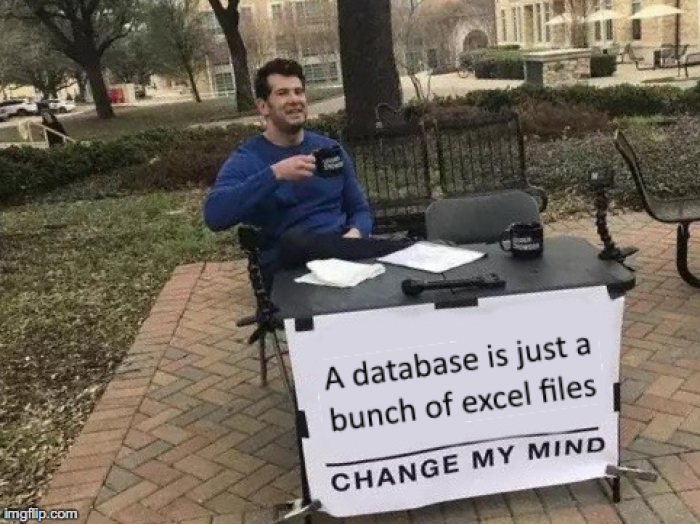


## What you will learn

- How to build a custom pipeline using SQL sources
- How to use `query_adapter_callback`, `table_adapter_callback`, and `type_adapter_callback`
- How to load only new data with incremental loading


Setup & install dlt:

In [1]:
%%capture
!pip install pymysql duckdb dlt

## Step 1: Load data from SQL Databases

We’ll use the [Rfam MySQL public DB](https://docs.rfam.org/en/latest/database.html) and load it into DuckDB:

In [2]:
from dlt.sources.sql_database import sql_database
import dlt

source = sql_database(
    "mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam",
    table_names=["family"]
)

pipeline = dlt.pipeline(
    pipeline_name="sql_database_example",
    destination="duckdb",
    dataset_name="sql_data",
    dev_mode=True,
)

load_info = pipeline.run(source)
print(load_info)

Pipeline sql_database_example load step completed in 2.64 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data_20250510090924
The duckdb destination used duckdb:////content/sql_database_example.duckdb location to store data
Load package 1746868164.848974 is LOADED and contains no failed jobs


Explore the `family` table:

In [3]:
pipeline.dataset().family.df().head()

,rfam_acc,rfam_id,auto_wiki,description,author,seed_source,gathering_cutoff,trusted_cutoff,noise_cutoff,comment,...,ecmli_cal_hits,maxl,clen,match_pair_node,hmm_tau,hmm_lambda,created,updated,_dlt_load_id,_dlt_id
0,RF00001,5S_rRNA,1302,5S ribosomal RNA,"Griffiths-Jones SR, Mifsud W, Gardner PP","Szymanski et al, 5S ribosomal database, PMID:1...",38.0,38.0,37.9,5S ribosomal RNA (5S rRNA) is a component of t...,...,225645,196,120,1,-3.7679,0.71820,2013-10-03 20:41:44+00:00,2024-09-09 21:15:12+00:00,1746868164.848974,JRhRzuSE3zUp5w
1,RF00002,5_8S_rRNA,1303,5.8S ribosomal RNA,"Griffiths-Jones SR, Mifsud W","Wuyts et al, European LSU rRNA database, PMID:...",42.0,42.0,41.9,5.8S ribosomal RNA (5.8S rRNA) is a component ...,...,407997,265,154,1,-3.4977,0.71788,2013-10-03 20:47:00+00:00,2024-09-10 04:51:11+00:00,1746868164.848974,XO7LJbC+vgdLog
2,RF00003,U1,1304,U1 spliceosomal RNA,"Griffiths-Jones SR, Mifsud W, Moxon SJ, Ontive...","Zwieb C, The uRNA database, PMID:9016512",66.0,66.0,65.9,U1 is a small nuclear RNA (snRNA) component of...,...,410919,262,166,1,-3.7311,0.71618,2013-10-03 20:57:11+00:00,2024-09-09 21:15:12+00:00,1746868164.848974,m70m1BJ4s+6EVw
3,RF00004,U2,1305,U2 spliceosomal RNA,"Griffiths-Jones SR, Mifsud W, Gardner PP","The uRNA database, PMID:9016512; Griffiths-Jon...",46.0,46.0,45.9,U2 is a small nuclear RNA (snRNA) component of...,...,404187,292,192,1,-3.4862,0.71304,2013-10-03 20:58:30+00:00,2024-09-10 04:51:11+00:00,1746868164.848974,quDlmmwao0TdRw
4,RF00005,tRNA,1306,tRNA,"Eddy SR, Griffiths-Jones SR, Mifsud W",Eddy SR,29.0,29.0,28.9,Transfer RNA (tRNA) molecules are approximatel...,...,281040,217,71,1,-2.6284,0.73562,2013-10-03 21:00:26+00:00,2024-09-10 04:51:11+00:00,1746868164.848974,ZPuKkewlSjJYDA


## Step 2: Customize SQL queries with `query_adapter_callback`

You can fully rewrite or modify the SQL SELECT statement per table.


### Filter rows using a WHERE clause

In [4]:
from sqlalchemy import text

def query_adapter_callback(query, table, incremental=None, engine=None):
    return text(f"SELECT * FROM {table.fullname} WHERE rfam_id like '%bacteria%'")

To be able to use `sql_database` and not have to declare the connection string each time, we save it as an environment variable. This can also (should preferably) be done in `secrets.toml`

In [5]:
import os

os.environ["SOURCES__SQL_DATABASE__CREDENTIALS"] = "mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam"

In [6]:
filtered_resource = sql_database(
    query_adapter_callback=query_adapter_callback,
    table_names=["family"]
)

Let's save this filtered data:

In [7]:
info = pipeline.run(filtered_resource, table_name="bacterias")
print(info)

Pipeline sql_database_example load step completed in 0.29 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data_20250510090924
The duckdb destination used duckdb:////content/sql_database_example.duckdb location to store data
Load package 1746868277.7249975 is LOADED and contains no failed jobs


Explore the data:

In [8]:
pipeline.dataset().bacterias.df().head()

,rfam_acc,rfam_id,auto_wiki,description,author,seed_source,gathering_cutoff,trusted_cutoff,noise_cutoff,comment,...,ecmli_cal_hits,maxl,clen,match_pair_node,hmm_tau,hmm_lambda,created,updated,_dlt_load_id,_dlt_id
0,RF00169,Bacteria_small_SRP,1315,Bacterial small signal recognition particle RNA,Gardner PP,Published; PMID:19838050,40.0,40.0,39.9,The signal recognition particle (SRP) is a uni...,...,126368,150,97,1,-4.1586,0.71858,2013-10-03 23:42:19+00:00,2024-09-10 04:51:11+00:00,1746868277.7249975,JqnyPch74i//6w
1,RF00177,SSU_rRNA_bacteria,1459,Bacterial small subunit ribosomal RNA,"Gutell RR, Nawrocki E",Published; PMID:11869452,50.0,50.0,49.9,None,...,269430,1851,1533,1,-5.9525,0.69565,2013-10-03 23:45:40+00:00,2024-09-10 04:51:11+00:00,1746868277.7249975,0yWTXr0EuBFUnQ
2,RF01854,Bacteria_large_SRP,1315,Bacterial large signal recognition particle RNA,Gardner PP,Published; PMID:19838050,60.0,60.0,59.9,The signal recognition particle (SRP) is a uni...,...,263577,391,256,1,-3.7444,0.70828,2013-10-04 02:52:55+00:00,2024-09-10 04:51:11+00:00,1746868277.7249975,vkv9OibuZpFJyA
3,RF02278,Betaproteobacteria_toxic_sRNA,2316,Betaproteobacteria toxic small RNA,"Levy A, Burge SW",Levy A; Burge SW,50.0,50.0,49.9,Overexpression in amino aid rich medium attenu...,...,467860,135,64,1,-3.5182,0.71923,2013-10-04 03:30:22+00:00,2024-09-10 04:51:11+00:00,1746868277.7249975,w5arY8lQGRw9HQ
4,RF02541,LSU_rRNA_bacteria,1459,Bacterial large subunit ribosomal RNA,"Gutell RR, Nawrocki E",Published; PMID:11869452,50.0,50.0,49.9,None,...,264008,3854,2925,1,-6.6805,0.69446,2014-06-11 16:04:37+00:00,2024-09-10 04:51:11+00:00,1746868277.7249975,M1HM4UItf6O+kQ


### **Question 1**:

How many rows are present in the `bacterias` table?

**-->37**

>Answer this question and select the correct option in the homework Google Form.


## Step 3: Modify table schema with `table_adapter_callback`

Add columns, change types, or transform schema using this hook.


### Example: Add computed column `max_timestamp`

In [9]:
import sqlalchemy as sa
from sqlalchemy.sql import sqltypes

def add_max_timestamp(table):
    max_ts = sa.func.greatest(table.c.created, table.c.updated).label("max_timestamp")
    subq = sa.select(*table.c, max_ts).subquery()
    return subq

Use it with `sql_table`:

In [10]:
from dlt.sources.sql_database import sql_table

table = sql_table(
    table="family",
    table_adapter_callback=add_max_timestamp,
    incremental=dlt.sources.incremental("max_timestamp")
)

info = pipeline.run(table, table_name="family_with_max_timestamp")
print(info)

2025-05-10 09:13:26,654|[WARNING]|254|138025036922880|dlt|schema_types.py|sqla_col_to_column_schema:149|A column with name max_timestamp contains unknown data type NULL which cannot be mapped to `dlt` data type. When using sqlalchemy backend such data will be passed to the normalizer. In case of `pyarrow` and `pandas` backend, data types are detected from numpy ndarrays. In case of other backends, the behavior is backend-specific.
2025-05-10 09:13:26,717|[WARNING]|254|138025036922880|dlt|schema_types.py|sqla_col_to_column_schema:149|A column with name max_timestamp contains unknown data type NULL which cannot be mapped to `dlt` data type. When using sqlalchemy backend such data will be passed to the normalizer. In case of `pyarrow` and `pandas` backend, data types are detected from numpy ndarrays. In case of other backends, the behavior is backend-specific.
2025-05-10 09:13:29,713|[WARNING]|254|138025036922880|dlt|__init__.py|_check_duplicate_cursor_threshold:593|Large number of record

Pipeline sql_database_example load step completed in 2.25 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data_20250510090924
The duckdb destination used duckdb:////content/sql_database_example.duckdb location to store data
Load package 1746868406.6952176 is LOADED and contains no failed jobs


Let's check out if this column exists!

In [11]:
pipeline.dataset().family_with_max_timestamp.df().head()

,rfam_acc,rfam_id,auto_wiki,description,author,seed_source,gathering_cutoff,trusted_cutoff,noise_cutoff,comment,...,maxl,clen,match_pair_node,hmm_tau,hmm_lambda,created,updated,max_timestamp,_dlt_load_id,_dlt_id
0,RF00001,5S_rRNA,1302,5S ribosomal RNA,"Griffiths-Jones SR, Mifsud W, Gardner PP","Szymanski et al, 5S ribosomal database, PMID:1...",38.0,38.0,37.9,5S ribosomal RNA (5S rRNA) is a component of t...,...,196,120,1,-3.7679,0.71820,2013-10-03 20:41:44+00:00,2024-09-09 21:15:12+00:00,2024-09-09 21:15:12+00:00,1746868406.6952176,/AgECkD/lwuRDg
1,RF00002,5_8S_rRNA,1303,5.8S ribosomal RNA,"Griffiths-Jones SR, Mifsud W","Wuyts et al, European LSU rRNA database, PMID:...",42.0,42.0,41.9,5.8S ribosomal RNA (5.8S rRNA) is a component ...,...,265,154,1,-3.4977,0.71788,2013-10-03 20:47:00+00:00,2024-09-10 04:51:11+00:00,2024-09-10 04:51:11+00:00,1746868406.6952176,AYHfhEx+CPXiXg
2,RF00003,U1,1304,U1 spliceosomal RNA,"Griffiths-Jones SR, Mifsud W, Moxon SJ, Ontive...","Zwieb C, The uRNA database, PMID:9016512",66.0,66.0,65.9,U1 is a small nuclear RNA (snRNA) component of...,...,262,166,1,-3.7311,0.71618,2013-10-03 20:57:11+00:00,2024-09-09 21:15:12+00:00,2024-09-09 21:15:12+00:00,1746868406.6952176,WbYsRxeeDICdyA
3,RF00004,U2,1305,U2 spliceosomal RNA,"Griffiths-Jones SR, Mifsud W, Gardner PP","The uRNA database, PMID:9016512; Griffiths-Jon...",46.0,46.0,45.9,U2 is a small nuclear RNA (snRNA) component of...,...,292,192,1,-3.4862,0.71304,2013-10-03 20:58:30+00:00,2024-09-10 04:51:11+00:00,2024-09-10 04:51:11+00:00,1746868406.6952176,2CP5cNTQ6yllPw
4,RF00005,tRNA,1306,tRNA,"Eddy SR, Griffiths-Jones SR, Mifsud W",Eddy SR,29.0,29.0,28.9,Transfer RNA (tRNA) molecules are approximatel...,...,217,71,1,-2.6284,0.73562,2013-10-03 21:00:26+00:00,2024-09-10 04:51:11+00:00,2024-09-10 04:51:11+00:00,1746868406.6952176,yNjFa03tsOQjUw


## Step 4: Adapt column data types with `type_adapter_callback`

When the default types don’t match what you want in the destination, you can remap them.

Let's look at the schema that has already been loaded:

In [12]:
schema = pipeline.default_schema.to_dict()["tables"]["family"]["columns"]
for column in schema:
  print(schema[column]["name"], ":", schema[column]["data_type"])

rfam_acc : text
rfam_id : text
auto_wiki : bigint
description : text
author : text
seed_source : text
gathering_cutoff : decimal
trusted_cutoff : decimal
noise_cutoff : decimal
comment : text
previous_id : text
cmbuild : text
cmcalibrate : text
cmsearch : text
num_seed : bigint
num_full : bigint
num_genome_seq : bigint
num_refseq : bigint
type : text
structure_source : text
number_of_species : bigint
number_3d_structures : bigint
num_pseudonokts : bigint
tax_seed : text
ecmli_lambda : decimal
ecmli_mu : decimal
ecmli_cal_db : bigint
ecmli_cal_hits : bigint
maxl : bigint
clen : bigint
match_pair_node : bigint
hmm_tau : decimal
hmm_lambda : decimal
created : timestamp
updated : timestamp
_dlt_load_id : text
_dlt_id : text


Lets change `hmm_lambda` from decimal to double.

💡 Quick fyi: The `double` data type is:
- Fast and uses less space
- But it's approximate — you may get 0.30000000000000004 instead of 0.3
- Bad for money, great for probabilities, large numeric ranges, scientific values

### Example: Change data types

In [13]:
import sqlalchemy as sa

def type_adapter_callback(sql_type):
  if isinstance(sql_type, sa.Numeric):
        return sa.Double
  return sql_type

Use it with `sql_database`:

In [14]:
new_source = sql_database(
    type_adapter_callback=type_adapter_callback,
    table_names=["family"]
)

info = pipeline.run(new_source, table_name="type_changed_family")
print(info)

Pipeline sql_database_example load step completed in 2.17 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data_20250510090924
The duckdb destination used duckdb:////content/sql_database_example.duckdb location to store data
Load package 1746868463.083208 is LOADED and contains no failed jobs


👀 Can you see how the column data types have changed?

In [15]:
schema1 = pipeline.default_schema.to_dict()["tables"]["family"]["columns"]
schema2 = pipeline.default_schema.to_dict()["tables"]["type_changed_family"]["columns"]
column = "trusted_cutoff"

print("For table 'family':", schema1[column]["name"], ":", schema1[column]["data_type"])
print("For table 'type_changed_family':", schema2[column]["name"], ":", schema2[column]["data_type"])

For table 'family': trusted_cutoff : decimal
For table 'type_changed_family': trusted_cutoff : double


### **Question 2**:

How many columns had their type changed in the `type_changed_family` table?

**-->7**


In [18]:
all_keys = set(schema1.keys()) | set(schema2.keys())
diff_count = 0

for key in sorted(all_keys):
    val1 = schema1.get(key)
    val2 = schema2.get(key)
    if val1 != val2:
        print(f"Difference in '{key}': schema1={val1}, schema2={val2}")
        diff_count += 1

print(f"\nTotal differences: {diff_count}")


Difference in 'ecmli_lambda': schema1={'name': 'ecmli_lambda', 'nullable': True, 'data_type': 'decimal', 'precision': 10, 'scale': 5}, schema2={'name': 'ecmli_lambda', 'nullable': True, 'data_type': 'double'}
Difference in 'ecmli_mu': schema1={'name': 'ecmli_mu', 'nullable': True, 'data_type': 'decimal', 'precision': 10, 'scale': 5}, schema2={'name': 'ecmli_mu', 'nullable': True, 'data_type': 'double'}
Difference in 'gathering_cutoff': schema1={'name': 'gathering_cutoff', 'nullable': True, 'data_type': 'decimal', 'precision': 5, 'scale': 2}, schema2={'name': 'gathering_cutoff', 'nullable': True, 'data_type': 'double'}
Difference in 'hmm_lambda': schema1={'name': 'hmm_lambda', 'nullable': True, 'data_type': 'decimal', 'precision': 10, 'scale': 5}, schema2={'name': 'hmm_lambda', 'nullable': True, 'data_type': 'double'}
Difference in 'hmm_tau': schema1={'name': 'hmm_tau', 'nullable': True, 'data_type': 'decimal', 'precision': 10, 'scale': 5}, schema2={'name': 'hmm_tau', 'nullable': True, 

## Step 5: Incremental loads with `sql_database`
Track only new rows using a timestamp or ID column.

We'll also be looking at where these incremental values are stored.

Hint: they are stored in [dlt state](https://dlthub.com/docs/general-usage/state).

In [19]:
import json
with open("/var/dlt/pipelines/sql_database_example/state.json", "r") as f:
  data = json.load(f)

data["sources"]["sql_database"]["resources"]["family"]["incremental"].keys()

dict_keys(['max_timestamp'])

In [20]:
from dlt.sources.sql_database import sql_database
import pendulum

source = sql_database().with_resources("family")
source.family.apply_hints(
    incremental=dlt.sources.incremental("updated", initial_value=pendulum.datetime(2024, 1, 1))
)

info = pipeline.run(source)
print(info)

2025-05-10 09:20:27,946|[WARNING]|254|138025036922880|dlt|__init__.py|_check_duplicate_cursor_threshold:593|Large number of records (832) sharing the same value of cursor field 'updated'. This can happen if the cursor field has a low resolution (e.g., only stores dates without times), causing many records to share the same cursor value. Consider using a cursor column with higher resolution to reduce the deduplication state size.


Pipeline sql_database_example load step completed in 2.22 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data_20250510090924
The duckdb destination used duckdb:////content/sql_database_example.duckdb location to store data
Load package 1746868824.4997156 is LOADED and contains no failed jobs


In [21]:
import json
with open("/var/dlt/pipelines/sql_database_example/state.json", "r") as f:
  data = json.load(f)

data["sources"]["sql_database"]["resources"]["family"]["incremental"].keys()

dict_keys(['max_timestamp', 'updated'])

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1P8pOw9C6J9555o2jhZydESVuVb-3z__y#forceEdit=true&sandboxMode=true)!